In [95]:
import pandas as pd
import datetime as dt
import pytz
import matplotlib.pyplot as plt

## Import historic data

Data is 2000 - 2019 NASA reanalysis satelite data - obtained from renewables.ninja

In [31]:
# hourly vector from 2000 - 2019
oxford_weather = oxford_weather = pd.read_csv("oxford_RN_weather_2000_2019.csv",
                             index_col=0, parse_dates=True)

# convert local time stamp to UTC datetime, when using later, use UTC rather than local time (e.g. use GMT not BST)
oxford_weather.reset_index(inplace=True)
oxford_weather["UTC datetime"] = oxford_weather["local_time"].apply(lambda x: x.astimezone(pytz.utc))
oxford_weather["hour"] = oxford_weather["UTC datetime"].apply(lambda x: x.hour)
oxford_weather["date"] = oxford_weather["UTC datetime"].apply(lambda x: x.date)

In [159]:
# only interested in temperature
ox_T = oxford_weather[["UTC datetime", "hour", "date", "temperature"]]
ox_T.set_index("UTC datetime", inplace=True)

In [38]:
# mean temperature each day in range 2000 - 2019
ox_daily_T = ox_T["temperature"].groupby(pd.Grouper(freq='D')).mean()

In [39]:
# reshape vector so to be days (rows) vs time (cols)
ox_T_M = ox_T.pivot(index="date", columns="hour", values="temperature")

## Aggregating historic temperature
First trying hourly average over the 20 years history. Might think about smoothing with a rolling average before taking average.

In [162]:
ox_T_M_test = ox_T_M.copy()
ox_T_M_test["day"] = pd.to_datetime(ox_T_M.index).strftime('%m-%d')

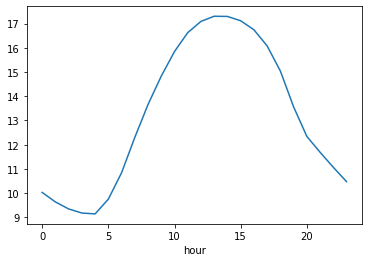

In [187]:
ox_T_M_test_birthday = ox_T_M_test[ox_T_M_test['day']=='05-28'].drop('day', axis=1)
ox_T_M_test_birthday_mean = ox_T_M_test_birthday.mean()
ox_T_M_test_birthday_mean.plot()

In [94]:
# create an average hourly profile for each day of the year, averaged over 20 years.
ox_T_M_daily = ox_T_M.groupby(pd.to_datetime(ox_T_M.index).strftime('%m-%d')).mean()
ox_T_M_daily_std = ox_T_M.groupby(pd.to_datetime(ox_T_M.index).strftime('%m-%d')).std()

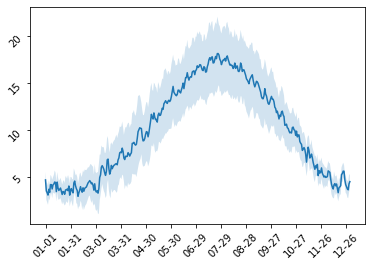

In [197]:
# plot daily (avg) temperature of 20 year mean hourly profile
ox_T_daily_avg = ox_T_M_daily.T.describe().T

fig, ax = plt.subplots()
ax.fill_between(x=ox_T_daily_avg.index, y1=(ox_T_daily_avg["mean"]-ox_T_daily_avg["std"]),
                y2=(ox_T_daily_avg["mean"]+ox_T_daily_avg["std"]), alpha=0.2)
ax.plot(ox_T_daily_avg.index, ox_T_daily_avg["mean"])
ax.set_xticks(range(0,366,30))
ax.tick_params(labelrotation=45)

In [196]:
ox_T_daily_avg.loc['05-28']

count    24.000000
mean     13.206815
std       3.046239
min       9.141950
25%      10.362175
50%      12.951475
75%      16.212875
max      17.300300
Name: 05-28, dtype: float64

In [206]:
# is it different if you first calculate the daily temperature, then take the mean across 20 years. Yes
ox_daily_T_mean = pd.DataFrame(ox_daily_T.copy())
ox_daily_T_mean["day"] = pd.to_datetime(ox_daily_T.index).strftime('%m-%d')
ox_daily_T_mean = ox_daily_T_mean.groupby('day').mean()
ox_daily_T_mean.loc['05-28']

temperature    13.206815
Name: 05-28, dtype: float64

In [144]:
# normalise daily profiles
ox_T_daily_norm = ox_T_M_daily.divide(ox_T_daily_avg["mean"], axis=0)
ox_T_daily_std_norm = ox_T_M_daily_std.divide(ox_T_daily_avg["mean"], axis=0)

In [184]:
def forecast_weather_profile(historic_norm, historic_norm_std, daily_avg,
                             date='05-28', daily_T=None):
    """
    parameters
    ----------
    date: str
        'MM-DD'
    """
    if isinstance(daily_T, type(None)):
        daily_T = daily_avg.loc[date]['mean']
    daily_norm = historic_norm.loc[date,:]
    daily_std = historic_norm_std.loc[date,:]
    forecast = daily_norm * daily_T
    forecast_std = daily_std * daily_T
    plt.plot(forecast)
    plt.fill_between(x=forecast.T.index,
                     y1=forecast-forecast_std,
                     y2=forecast+forecast_std, alpha=0.1)
    return pd.DataFrame({"temperature":forecast.T, "std": forecast_std.T})

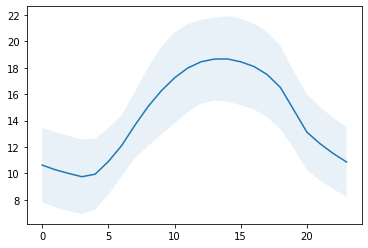

In [189]:
westgate_8thjune = forecast_weather_profile(ox_T_daily_norm,
                                            ox_T_daily_std_norm,
                                            ox_T_daily_avg,
                                            '06-08',
                                            )

In [207]:
westgate_8thjune.to_csv("westgate_8June_profile.csv")